# MVA - Kernel Methods - Data Challenge

In [1]:
from os.path import exists
import numpy as np
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import optimize
import seaborn as sns

# from skimage.draw import line

if not exists('mva-mash-kernel-methods-2021-2022'):
    with zipfile.ZipFile('mva-mash-kernel-methods-2021-2022.zip', 'r') as zip_ref:
        zip_ref.extractall('mva-mash-kernel-methods-2021-2022')

Xtr = np.array(pd.read_csv('mva-mash-kernel-methods-2021-2022\\mva-mash-kernel-methods-2021-2022\\Xtr.csv',header=None,sep=',',usecols=range(3072)))[:100]
Xte = np.array(pd.read_csv('mva-mash-kernel-methods-2021-2022\\mva-mash-kernel-methods-2021-2022\\Xte.csv',header=None,sep=',',usecols=range(3072)))[:100]
Ytr = np.array(pd.read_csv('mva-mash-kernel-methods-2021-2022\\mva-mash-kernel-methods-2021-2022\\Ytr.csv',sep=',',usecols=[1])).squeeze()[:100]

### Utils for image processing

In [2]:
def row_to_img (row, rescale = False, grayscale = False) : 
    # Convert a row of shape 3072 to an image 32 x 32 x 3 or 32 x 32
    # if rescale == True, put pixel values between 0 and 1 :
    img = np.moveaxis(row.reshape(3,32,32),0,-1)
    if grayscale : 
      img = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114* img[:,:,2]
    if rescale : 
      img = (img - img.min()) / (img.max() - img.min())
    return img

def img_to_row (img, grayscale = False) : 
    # Convert an image of shape 32x32 or 32x32x3 into a row of shape 1024 or 3072
    if not(grayscale) : 
        img = np.moveaxis(img,-1,0)
    return img.ravel()

def row_to_flipped_row (row) : 
    # Convert a row of an image into the row of the horizontally flipped image (with images in RGB !)
    img = row_to_img(row)

    img_flipped = np.zeros(img.shape)
    for i in range(3) : 
        img_flipped[:,:,i] = img[:,::-1,i]
    
    return img_to_row(img_flipped)

def row_to_gray_row (row) : 
    # Convert a row of shape 3072 to the row of a grayscale image of shape 1024
    img = np.moveaxis(row.reshape(3,32,32),0,-1)
    gray_img = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114* img[:,:,2]
    gray_row = np.ravel(gray_img)
    return gray_row

def augmented_dataset(X, y):
    return np.concatenate([X, np.apply_along_axis(row_to_flipped_row, axis=1, arr=X)]), np.concatenate([y, y])

def plot_random_images (X, Y, grayscale = False, nb_images=3) : 
    fig, ax = plt.subplots(nb_images,10, figsize=(50,5*nb_images))

    classes = ["plane", "car", "bird", "car", "deer", "dog", "frog", "horse", "boat", "truck"]

    for axi, c in zip(ax[0], np.arange(10)):
        axi.set_title(f'Category {c} : {classes[c]}',fontsize=26)
    fig.tight_layout()

    for c in range(10) : 
        # Selection of nb_images random images of class c+1 in Xtr :
        Y_c = np.argwhere(Y==c).reshape(-1)
        random_indices = np.random.choice(Y_c, size=nb_images, replace=False)

        for k,i in enumerate(random_indices) : 
            img = row_to_img(X[i], rescale=True, grayscale = grayscale)
            cmap = 'gray' if grayscale else None
            ax[k,c].imshow(img, cmap = cmap)

    plt.show()

## Grayscale Dataset

In [3]:
Xtr_grs = np.apply_along_axis(row_to_gray_row, axis=1, arr=Xtr)
Xte_grs = np.apply_along_axis(row_to_gray_row, axis=1, arr=Xte)

### Visualization

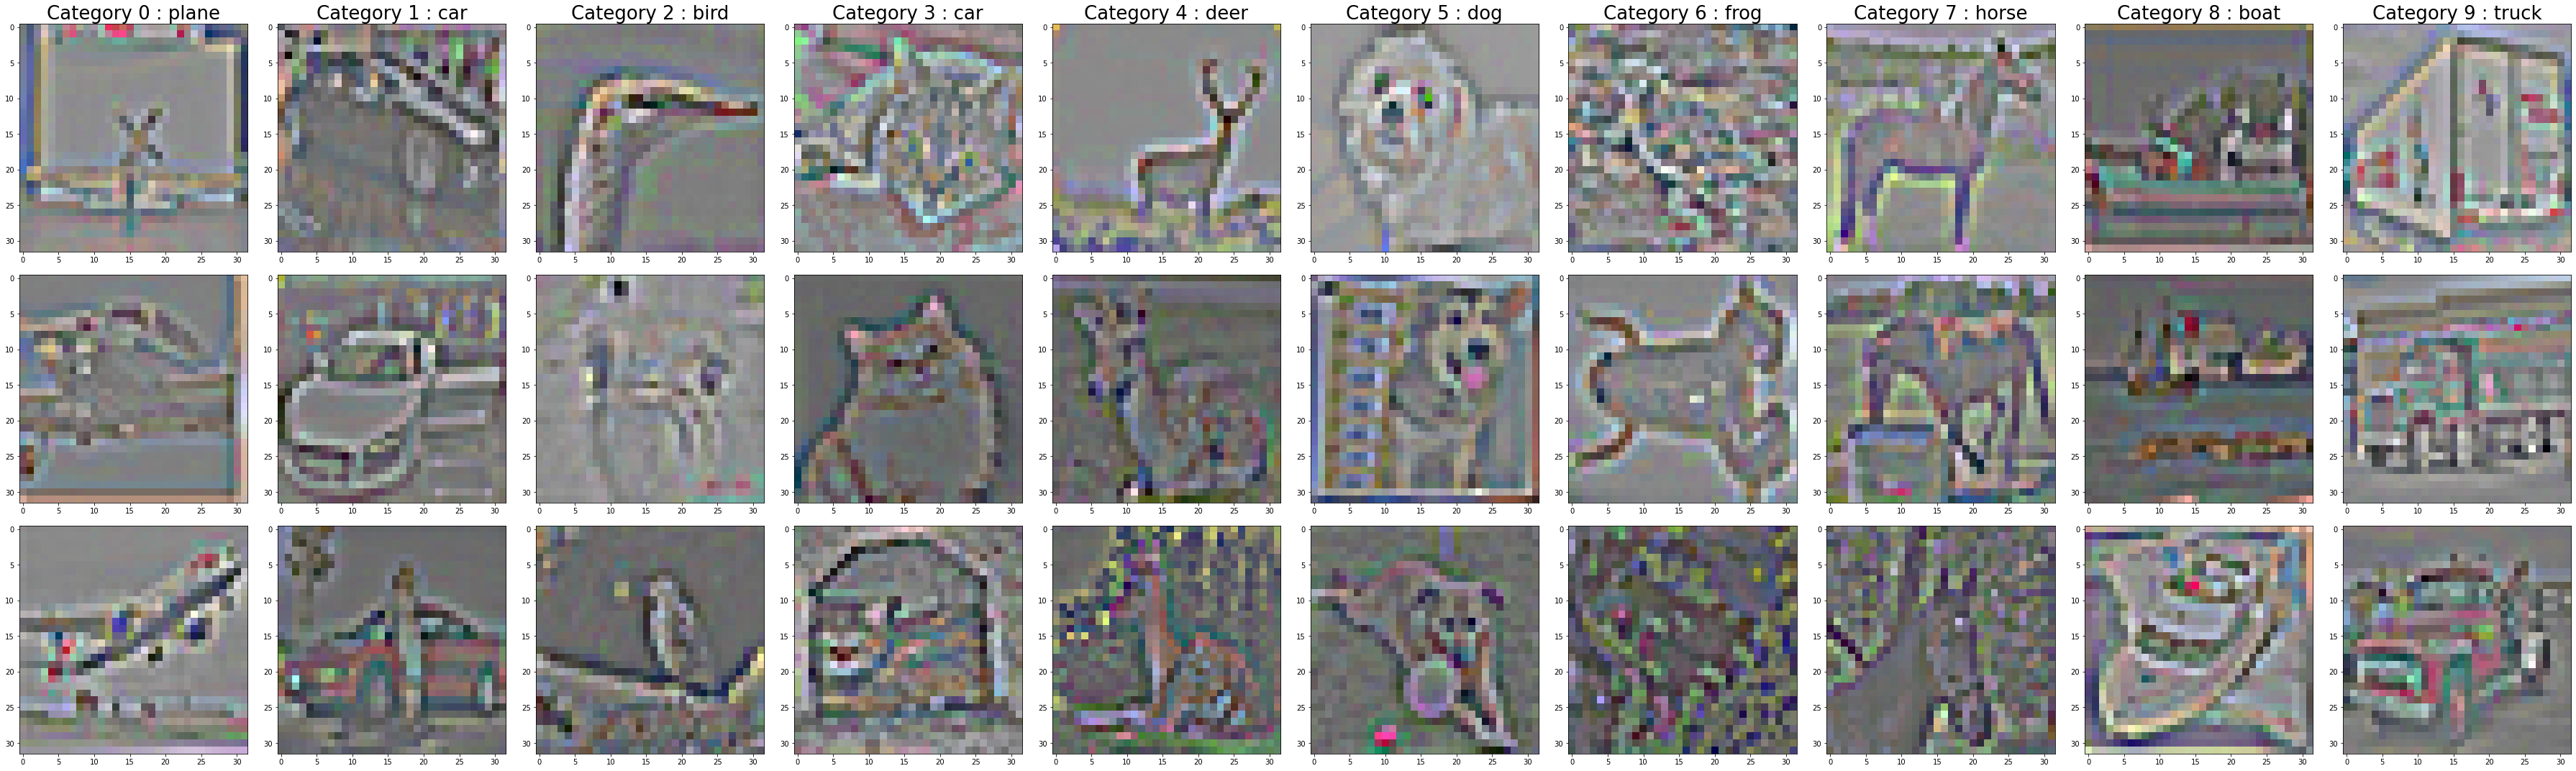

In [4]:
plot_random_images(Xtr, Ytr)

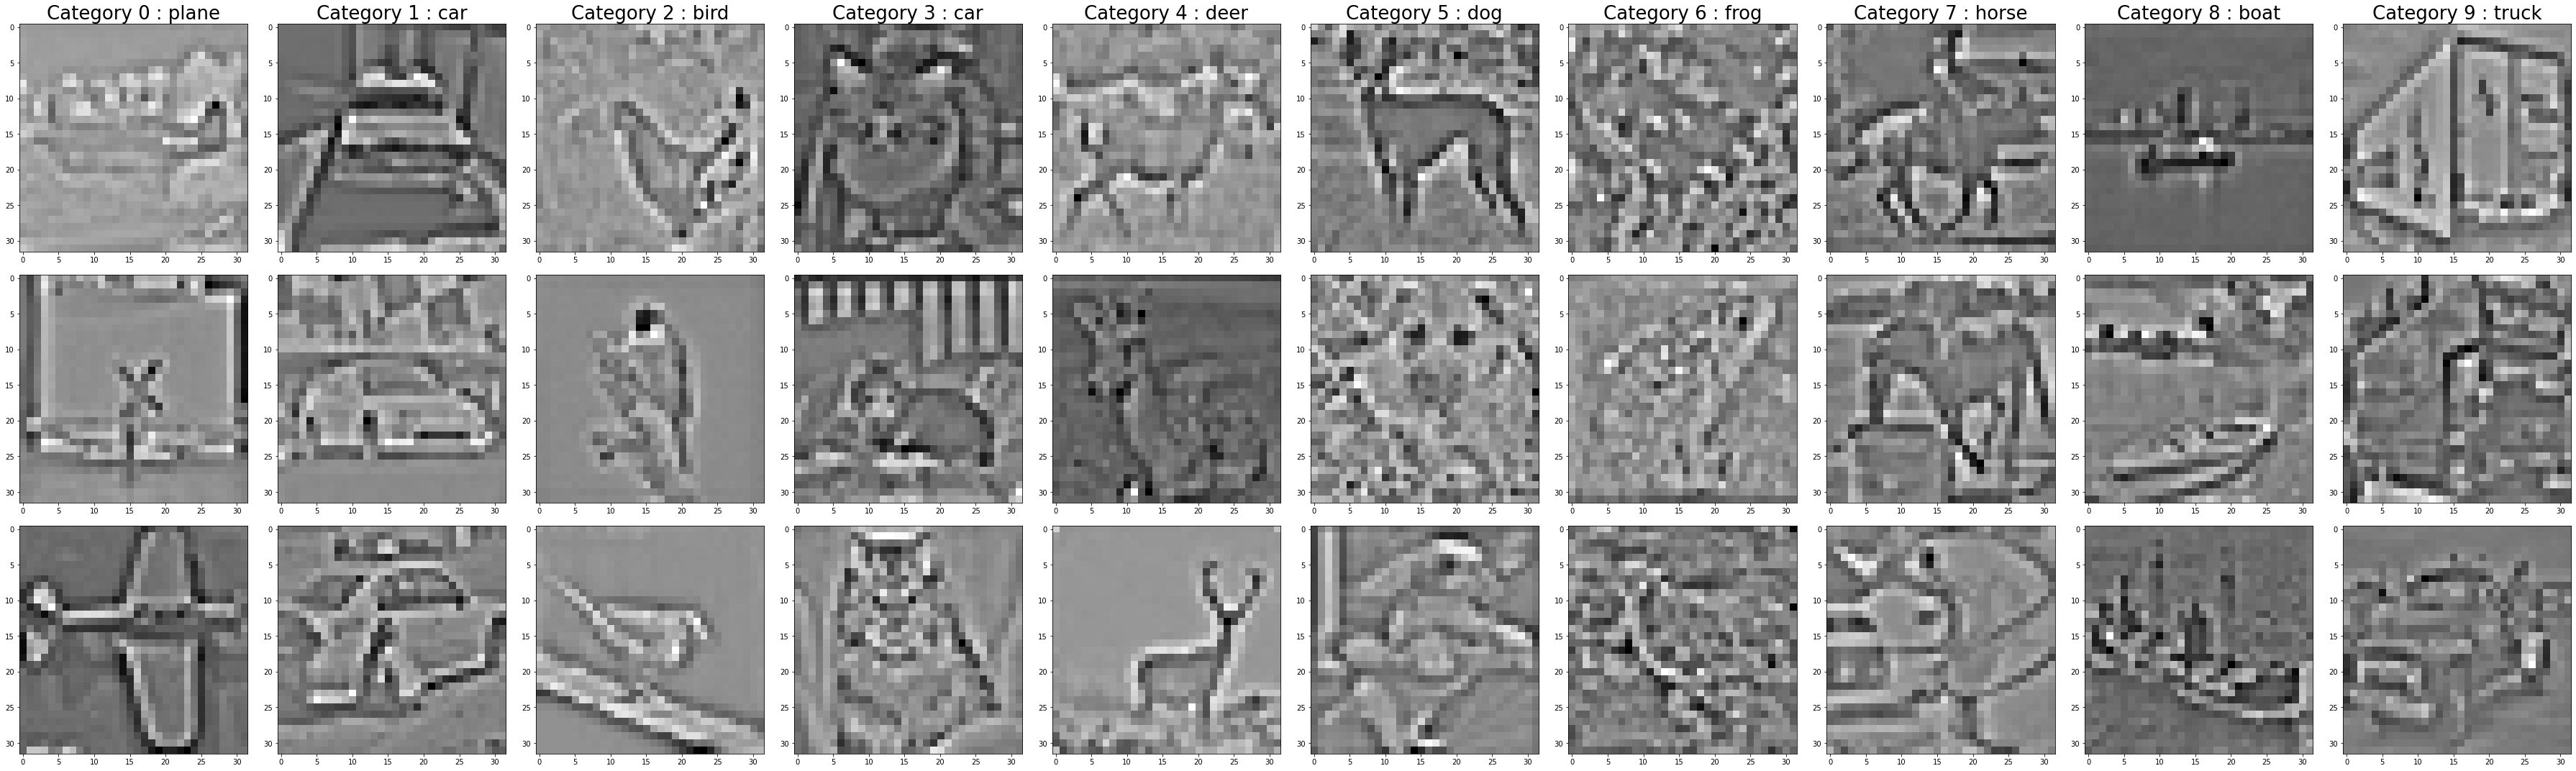

In [5]:
plot_random_images(Xtr, Ytr, grayscale = True)

## Kernels

In [6]:
class Linear:
    def __init__(self):
        self.name= 'linear'
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return np.einsum('nd,md->nm',X,Y)
        
        
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
        self.name = 'RBF'
    def kernel(self,X,Y):
        squared_norm = np.expand_dims(np.sum(X**2,axis=1),axis=1) + np.expand_dims(np.sum(Y**2,axis=1),axis=0)-2*np.einsum('ni,mi->nm',X,Y)
        return np.exp(-0.5*squared_norm/self.sigma**2)


class Poly:
    def __init__(self, gamma, degree, coef0):
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.name= 'poly'
    def kernel(self,X,Y):
        return (self.gamma* np.einsum('nd,md->nm',X,Y) + self.coef0)**self.degree

class chi2:
    def __init__(self, gamma = 1.):
        self.gamma = gamma
        self.name = 'chi2'

    def kernel(self,X,Y):
        out = np.zeros((X.shape[0], Y.shape[0]))
        n_X = X.shape[0]
        n_Y = Y.shape[0]
        n_features = X.shape[1]

        for i in range(n_X):
            for j in range(n_Y):
                p = 0
                for k in range(n_features):
                    denominateur = (X[i, k] - Y[j, k])
                    nominateur = (X[i, k] + Y[j, k])
                    if nominateur != 0:
                        p += denominateur * denominateur / nominateur
                out[i, j] = -p
        tmp = self.gamma * out
        return  np.exp(tmp, tmp)

## Kernel-SVC classifier : 
 
- **one-vs-one** : $\frac{m(m-1)}{2}$ binary classifiers, with $m$ number of classes (here $m=10$, we need to train $45$ classifiers), between each possible couple of categories. The final class is the most predicted one. 

- **one-vs-rest** : we train $m$ classifiers, each one looking for a separation between a class and the rest of the data. After training, we choose the class corresponding to the classifier that leads to the higher value of the decision function.

In [7]:
class KernelSVC_Binary :

    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        y_diag = np.diag(y)
        K = self.kernel(X,X)

        # Lagrange dual problem
        def loss(alpha):
            A = y_diag@alpha
            one = np.ones((1,N))
            l = - one@alpha 
            l += ((A.T)@K@A)/2 
            return l[0] #'''--------------dual loss ------------------ '''

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            A = y_diag@alpha
            g_l = y_diag@(K@A) - np.ones(N)
            return g_l # '''----------------partial derivative of the dual loss wrt alpha-----------------'''


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

          # Equality constraint : y^T alpha = 0 
        fun_eq = lambda alpha: y.T @ alpha  # '''----------------function defining the equality constraint------------------'''       
        jac_eq = lambda alpha: y.T  #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
          # Inequality constraints : c 1l - Id alpha >= 0 & - Id alpha >= 0 
        fun_ineq = lambda alpha: np.concatenate((self.C*np.ones(N) , np.zeros(N))) - np.concatenate((np.identity(N),-np.identity(N))) @ alpha   # '''---------------function defining the ineequality constraint-------------------'''     
        jac_ineq = lambda alpha: - np.concatenate((np.identity(N) , -np.identity(N)))  # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes

        supportIndices = self.alpha > self.epsilon
        self.support = X[supportIndices] #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        self.coef_support = np.diag(y[supportIndices]) @ self.alpha[supportIndices]

        i = np.argmax(((self.alpha < self.C) + 1.*(self.alpha >  self.epsilon))==2) #find a vector such that y_i (f(x_i)+b) = 1 <=> b = y_i - f(x_i) = y_i - [K diag(y) alpha]_i
        A = y_diag@self.alpha
        self.b = y[i] - (K@A)[i] #''' ----------------- offset of the classifier ------------------ '''
        self.norm_f = A.T @ K @ A # '''------------------------RKHS norm of the function f ------------------------------'''


    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = self.kernel(x,self.support) 
        f = K @ self.coef_support
        return f
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1
    
class KernelSVC_OneVsOne :
    
    def __init__(self, num_classes, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.num_classes = num_classes
        self.pool = {} # contain the classifiers for all classes
        for i in range(self.num_classes) : 
            for j in range(i+1, self.num_classes) : 
                self.pool[(i,j)] = KernelSVC_Binary(C=C, kernel=kernel, epsilon=epsilon)
       
    def fit(self, X, y):
        m = self.num_classes
        indices_c = {}
        for i in range(m) : 
            indices_c[i] = np.argwhere(y==i).reshape(-1)

        progress_bar = tqdm_auto(range(m * (m-1) // 2))
        for i in range(m) : 
            for j in range(i+1, m) : 
                indices_ij = np.concatenate((indices_c[i],indices_c[j]))
                self.pool[(i,j)].fit(X[indices_ij], 2*(y[indices_ij]==i)-1)   
                progress_bar.update(1)   
    
    def predict(self, X):
        """ Predictions consist in choosing the category that has the higher number of votes """
        m = self.num_classes
        y = np.zeros((len(X), m))

        for i in range(m) : 
            for j in range(i+1, m) :
                classif_ij = self.pool[(i,j)].separating_function(X) + self.pool[(i,j)].b 
                classif_ij = 1*(classif_ij > 0) # 0 if class j and 1 if class i
                y[:,i] += classif_ij
                y[:,j] += 1 - classif_ij

        return y.argmax(axis=-1)
    
class KernelSVC_OneVsRest :
    
    def __init__(self, num_classes, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.num_classes = num_classes
        self.pool = {} # contain the classifiers for all classes
        for i in range(self.num_classes) :  
            self.pool[i] = KernelSVC_Binary(C=C, kernel=kernel, epsilon=epsilon)
       
    def fit(self, X, y):
        for i in tqdm(range(self.num_classes)) : 
            self.pool[i].fit(X, 2*(y==i)-1)
    
    def predict(self, X):
        """ Predictions consist in choosing the category for which the classifier gives the highest value of the decision function"""
        y = np.zeros((len(X), self.num_classes))
        for i in range(self.num_classes) :
            y[:,i] = self.pool[i].separating_function(X) + self.pool[i].b  # value of the decision function
  
        return y.argmax(axis=-1)

## Features Extraction from Images

### SIFT

In [8]:
import numpy as np
from tqdm import tqdm

class SIFT:
    def __init__(self, gs = 7, ps = 30, gaussian_thres = 0.6, gaussian_sigma = 0.4, sift_threshold = 0.3, num_angles = 12, bins = 5, alpha = 9.0):
        self.num_angles = num_angles
        self.bins = bins
        self.alpha = alpha
        self.angle_list = 2.0*np.pi*np.array(range(num_angles))/num_angles
        self.gs = gs
        self.ps = ps
        self.gaussian_thres = gaussian_thres
        self.gaussian_sigma = gaussian_sigma
        self.sift_threshold = sift_threshold
        self.weights = self.weights(bins)
    
    # Private Methods
    
    def gaussian_filter(self, sigma):
        # Here we create the grid of gaussian coefficients
        coeff = int(2*np.ceil(sigma))
        gaussian_range = np.array(range(-coeff, coeff+1))**2
        gaussian_range = gaussian_range[:, np.newaxis] + gaussian_range
        value = np.exp(- gaussian_range / (2.0 * sigma**2))
        value /= np.sum(value)
        height, width = np.gradient(gaussian_range)
        height *= 2.0/np.sum(np.abs(height))
        width  *= 2.0/np.sum(np.abs(width))
        return height, width
    
    def convolution_image_gaussian(self, image, gaussian):
        # Used to convolve with a grid of gaussian coefficients
        imR, imC = image.shape
        kR, kC = gaussian.shape
        y = np.zeros((imR,imC))
        center_kX, center_kY = kC//2, kR//2
        for i in range(imR):
            for j in range(imC):
                for m in range(kR):
                    m_ = kR - 1 - m
                    for n in range(kC):
                        n_ = kC - 1 - n
                        i_ = i + (m - center_kY)
                        j_ = j + (n - center_kX)
                        if i_ >= 0 and i_ < imR and j_ >= 0 and j_ < imC :
                            y[i][j] += image[i_][j_] * gaussian[m_][n_]
        return y
    
    def normalize_features(self, features):
        # Used to normalize the obtained features relatively to the gaussian threshold
        features_len = np.sqrt(np.sum(features**2, axis=1))
        hcontrast = (features_len >= self.gaussian_thres)
        features_len[features_len < self.gaussian_thres] = self.gaussian_thres
        features /= features_len.reshape((features_len.size, 1))
        features[features>self.sift_threshold] = self.sift_threshold
        features[hcontrast] /= np.sqrt(np.sum(features[hcontrast]**2, axis=1)).\
                reshape((features[hcontrast].shape[0], 1))
        return features
    
    def grid(self, image, grid_H, grid_W):
        # We extract features from the image using the grid and the gaussian convolutions 
        H, W = image.shape
        n_patches = grid_H.size
        features = np.zeros((n_patches, self.bins * self.bins * self.num_angles))
        height, width = self.gaussian_filter(self.gaussian_sigma)
        IH, IW = self.convolution_image_gaussian(image, height), self.convolution_image_gaussian(image, width)
        img = np.sqrt(IH**2 + IW**2)
        theta = np.arctan2(IH,IW)
        orient = np.zeros((self.num_angles, H, W))
        for i in range(self.num_angles):
            orient[i] = img * np.maximum(np.cos(theta - self.angle_list[i])**self.alpha, 0)
        for i in range(n_patches):
            feat = np.zeros((self.num_angles, self.bins**2))
            for j in range(self.num_angles):
                feat[j] = np.dot(self.weights,orient[j,grid_H[i]:grid_H[i]+self.ps, grid_W[i]:grid_W[i]+self.ps].flatten())
            features[i] = feat.flatten()
        return features

    def weights(self, bins):
        # Method to get weights from the grid
        size_unit = np.array(range(self.ps))
        sph, spw = np.meshgrid(size_unit, size_unit)
        sph.resize(sph.size)
        spw.resize(spw.size)
        bincenter = np.array(range(1, bins*2, 2)) / 2.0 / bins * self.ps - 0.5
        bincenter_h, bincenter_w = np.meshgrid(bincenter, bincenter)
        bincenter_h.resize((bincenter_h.size, 1))
        bincenter_w.resize((bincenter_w.size, 1))
        dist_ph = abs(sph - bincenter_h)
        dist_pw = abs(spw - bincenter_w)
        weights_h = dist_ph / (self.ps / np.double(bins))
        weights_w = dist_pw / (self.ps / np.double(bins))
        weights_h = (1-weights_h) * (weights_h <= 1)
        weights_w = (1-weights_w) * (weights_w <= 1)
        return weights_h * weights_w
    
    # Public Methods
    
    def get_features(self, image):
        image = image.astype(np.double)
        if image.ndim == 3:
            image = np.mean(image, axis=2)
        H, W = image.shape
        gS = self.gs
        pS = self.ps
        remH = np.mod(H-pS, gS)
        remW = np.mod(W-pS, gS)
        offsetH = remH//2
        offsetW = remW//2
        gridH, gridW = np.meshgrid(range(offsetH, H-pS+1, gS), range(offsetW, W-pS+1, gS))
        gridH = gridH.flatten()
        gridW = gridW.flatten()
        features = self.grid(image, gridH, gridW)
        features = self.normalize_features(features)
        pos = np.vstack((gridH / np.double(H), gridW / np.double(W)))
        return features, pos
    
    def get_features_from_data(self, data):
        out = []
        for idx in tqdm(range(len(data))):
            dt = data[idx]
            out.append(self.get_features(np.mean(np.double(dt), axis=2))[0][0])
        return np.array(out)

In [ ]:
sift = SIFT()
X_train_sift, y_train_sift = sift.get_features_from_data(Xtr[:-25].reshape((Xtr.shape[:-25][0], 32, 32, 3))), Ytr[:-25]
clf = KernelSVC_OneVsRest(num_classes = 10, C = 10., kernel = Linear().kernel)
clf.fit(X_train_sift, y_train_sift)
print('Accuracy : ', np.mean(clf.predict(X_train_sift[-25:]) == y_train_sift[-25:]))

### HoG

Computation of HoG feature descriptor (for grayscale images here) :

- Step 1 : it is recommended in the general case to use a global image normalization equalisation to "reduce the influence of illumination", but here as our images are "special" I skipped it for the moment.

- Step 2 : Computation of the gradients

  For this step, we apply two filter/"kernel" to obtain the horizontal and vertical gradient : $G_x = [-1,0,1]$ and $G_y=[-1,0,1]^T$. From that, we can deduce the gradient magnitude $G = \sqrt{G_x^2 + G_y^2}$ and the gradient orientation $\widehat{G} = \arctan\left(\frac{G_y}{G_x}\right) \mbox{ mod } 2 \pi$.

- Step 3 : Computation of the histograms per cell 

  We divide the set $[0,180]$ into $n_o$ subsets that will represent $n_o$ bins of the histograms. For each cell, we compute the mean of the gradients' magnitude of its pixels for each bins of orientation. 

- Step 4 : Normalization of the gradients' histograms per blocks

  We will consider blocks of cells and apply a normalization using the L2 norm. Note that in the skimage function, there is per default an 'hysteresis' that limits  the maximum value. For each block, we will store the normalized cells (some cells will then be duplicated but not normalized in the same way)
  
Implementation inspired from : 
  - [skimage hog function](https://github.com/scikit-image/scikit-image/blob/main/skimage/feature/_hog.py#L48-L307)
  - https://github.com/ahmedfgad/HOGNumPy/blob/master/HOG.py

In [ ]:
class HoG :

    def __init__ (self, orientations=8, pixels_per_cell=(8,8), cells_per_block=(2, 2)) :
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
    
    def gradients (self, img) :
        # Compute the gradients magnitude and orientation on an image of shape 32 x 32 (no color channel) 
        # Here simply apply Gx = [-1,0,1] and Gy = [-1,0,1]^T as it's simpler to code than convolutions with 2D kernels
        Gx, Gy = np.zeros(img.shape), np.zeros(img.shape)
        Gx[1:-1, :] = img[2:, :] - img[:-2, :]
        Gy[:, 1:-1] = img[:, 2:] - img[:, :-2]
        G = np.sqrt(Gx**2 + Gy**2)
        G_hat = (np.arctan(Gy/(Gx + 1e-10))*180/np.pi) % 180 # conversion in degree
        return G, G_hat

    def extract_features (self, X, visualization = False) : 
        # X should contain a grayscale image per row : X of shape n x 1024
        # output the features vector of shape n x nb_features
        # visualization allow to plot the orientation histograms during the extracting features process 
        features = None

        for i in tqdm(range(len(X))) :
            img = X[i].reshape((32,32))

            # Step 2 - Gradients' magnitude and orientation computation :
            G, G_hat = self.gradients(img)

            # Step 3 - Compute gradients histograms per cell :
            c_x, c_y = self.pixels_per_cell
            nb_cells_x = int(32 // c_x) 
            nb_cells_y = int(32 // c_y) 

            orientation_histogram = np.zeros((nb_cells_x, nb_cells_y, self.orientations), dtype=float) 

            for o in range(self.orientations) : 
                o_low, o_sup = (180/self.orientations)*o, (180/self.orientations)*(o+1) # considered range of orientations : G_hat in [o_low, o_sup]
                mask_o = (G_hat>=o_low)*(G_hat<o_sup) # pixels for which the orientation of the gradient corresponds to o
                masked_G = G * mask_o # put a magnitude to 0 when the orientation of the gradient do not corresponds to o

                for x in range(nb_cells_x) : 
                    for y in range(nb_cells_y) : 
                        # we are in cell (x,y), that is to say we consider the pixels in [x*c_x : (x+1)*c_x , y*c_y : (y+1)*c_y]
                        orientation_histogram[x,y,o] = np.mean(masked_G[x*c_x : (x+1)*c_x , y*c_y : (y+1)*c_y])

            if visualization : 
                v = self.visualize_histograms(orientation_histogram)


            # Step 4 - Normalization per block of cells :
            # For each block we store the normalized cells (some cells will then be duplicated but not normalized in the same way)
            b_x, b_y = self.cells_per_block
            nb_blocks_x = (nb_cells_x - b_x) + 1
            nb_blocks_y = (nb_cells_y - b_y) + 1
            normalized_blocks = np.zeros((nb_blocks_x, nb_blocks_y, b_x, b_x, self.orientations), dtype=float)

            for x in range(nb_blocks_x) :
                for y in range(nb_blocks_y) : 
                    # We are in block (x,y), that is to say in cells [x : x + b_x , y : y + b_y] (as we consider 'slippery' blocks)
                    block = orientation_histogram[x : x + b_x , y : y + b_y , :]
                    normalized_blocks[x,y,:] = block / np.sqrt(np.sum(block ** 2) + (1e-10) ** 2)

            # Step 5 - ravel to obtain a features vector
            f = normalized_blocks.ravel()

            # Add our features vector to the other ones :
            if features is None :
                nb_features = len(f)
                features = np.zeros((len(X), nb_features)) 
            features[i,:] = f

        return features


    def visualize_histograms (self, orientation_histogram) :
            visu = np.zeros((32,32), dtype=float)

            c_x, c_y = self.pixels_per_cell
            nb_cells_x, nb_cells_y, _ = orientation_histogram.shape

            # Prepare the midpoints of each cell to be abble to drax lines with some orientations
            orientations_array = np.arange(self.orientations)
            orientation_midpoints_rad = np.pi * (orientations_array + .5) / self.orientations # converted in rad

            radius = min(c_x, c_y) // 2 - 1
            orientation_midpoints_x = radius * np.sin(orientation_midpoints_rad)
            orientation_midpoints_y = radius * np.cos(orientation_midpoints_rad)

            # Fill the visualization per cell :
            for x in range(nb_cells_x) :
                for y in range(nb_cells_y) : 
                    # we are in cell (x,y), which grandients' histo is in orientation_histogram[x,y,:]
                    center_cell = x * c_x + (c_x // 2) ,  y * c_y + (c_y // 2)
                    for o in orientations_array : 
                        # For each orientation, we draw a line with "magnitude" given in orientation_histogram[x,y,o]
                        line_x, line_y = line(int(center_cell[0] - orientation_midpoints_x[o]),
                                       int(center_cell[1] + orientation_midpoints_y[o]),
                                       int(center_cell[0] + orientation_midpoints_x[o]),
                                       int(center_cell[1] - orientation_midpoints_y[o]))
                        visu[line_x, line_y] += orientation_histogram[x, y, o]
            
            # Plot :
            plt.imshow(visu)
            plt.show()

img = Xtr_artificial_grayscale[10].reshape((32,32))
plt.imshow(img, cmap='gray')
plt.show()
f = HoG(pixels_per_cell=(8,8)).extract_features ([img], visualization = True)

## Kernel PCA :

Might be used if we want to reduce the dimension of the features extracted from images. 

* Fit :
  
  Considering a training set of $n$ data points, the $i$-th principal direction corresponds to solving : 
  $$f_i = \arg \max_{f \perp \{f_1,...,f_{i-1}\}} \left\{ \sum_{i=1}^n (f(x_j))^2\right\} \mbox{ s.t. } \|f\|_{\mathcal{H}} = 1$$
  
  The solution corresponds to the function $f_i \in \mathcal{H}$ such as : $$f_i(x)=\sum_{j}^n \alpha_{ij}K(x_j,x) \mbox{, with } \alpha_i = \frac{1}{\sqrt{\Delta_i}}u_i$$
  by denoting $\Delta_i$ the $i$-th eigen value of the Gram matrix $K$ associated to the eigen vector $u_i$.
  To fit the kernel PCA, we then just have to compute and diagonalize the Gram matrix $K$ of our data, defined by $K_{ij} := K(x_i,x_j)$.
  
  **Attention :** points/features need to be centered, ie $\sum_{i=1}^n \varphi(x_i) = 0$. If it's not the case (in general), we have to center the Gram matrix before diagonalizing it. To do so, recall that we replace the Gram matrix $K$ by its centered version ([proof (p.59)](https://www.math.univ-toulouse.fr/~epauwels/LearningM2SID/kernelMethods.pdf)) : 
  $$\tilde{K} = K - UK - KU + UKU \mbox{, with } U = \frac{1}{n} \in \mathbb{R}^{n\times n}$$
  

* Projection : 

  The projections of the points on the $i$-th component corresponds to  $K\alpha_i$, with $K$ the gram matrix between the points used for the fitting and the points to project.

* Empirical variance : 

  To have an idea of the quality of the KPCA, we can compute the empirical variance captured by each component. It can also be used to choose the number of components (elbow rule).

  The empirical variance captured by the $i$-th component $f_i$ corresponds to : $$\widehat{v}_i = \frac{1}{n} \sum_{j=1}^n f_i(x_j)^2 = \frac{1}{n} \alpha_i^T K^2 \alpha_i = \frac{1}{n} \sum_{j=1}^n (K\alpha_i)_j^2$$



In [ ]:
class KernelPCA : 

    def __init__ (self, n_components, kernel) : 
        self.kernel = kernel
        self.n_components = n_components
        # We will store the training points and their values in :
        self.X_support = None # centered
        self.alpha_support = None
        self.components_norms = None # H-norms of the components
        # We will also store a fnuction to center the gram matrices :
        self.center = None

    def fit(self, X) : 

        n = len(X)
        self.X_support = X 

        # Compute the Gram Matrix :
        K = self.kernel(self.X_support,self.X_support) 

        # Create a function to be able to center any other gram matrix 
        K_mean_rows = np.mean(K, axis=0)
        K_mean = np.mean(K)
        def center (K_) : 
            K_ -= (np.sum(K_, axis=1) / n)[:, np.newaxis]
            K_ -= K_mean_rows
            K_ += K_mean
            return K_
        self.center = center
        K = self.center(K)

        # Diagonalization of the centered Gram matrix :
        eig_values, eig_vectors = eigh(K)
        eig_values, eig_vectors = eig_values[::-1], eig_vectors[::-1] # descendent order

        # Keep the n_components higher eigenvalues and associated eigenvectors : 
        eig_values_k = eig_values[:self.n_components] # shape n_components
        eig_vectors_k = eig_vectors[:,:self.n_components] # shape n x n_components
        self.eigen_values = eig_values_k

        # Flip eigenvectors' sign is recommended so that the entries that are largest in absolute value are positive : 
        indices = np.argmax(np.abs(eig_vectors_k), axis=0)
        signs = np.sign(eig_vectors_k[indices, range(self.n_components)])
        eig_vectors_k = eig_vectors_k * signs
        self.eigen_vectors = eig_vectors_k

        # Compute the alpha coef of the n_components first components :
        self.alpha_support = eig_vectors_k / np.sqrt(eig_values_k) 

        # We can store the H-norms of the components :
        self.components_norms = np.diag(self.alpha_support.T @ K @ self.alpha_support)

    def project(self, X) :

        # Kernel matrix between X and the data used for fitting :
        K = self.kernel(X, self.X_support)
        K = self.center(K)

        return K @ self.alpha_support

    def empirical_variance(self) : 
        # Compute the empirical variance captured by the kpca (after fitting)
        projection_X_support = self.project(self.X_support)
        return (projection_X_support**2).mean(axis=0)
    
kpca_rbf = KernelPCA(200, kernel = RBF().kernel)
kpca_rbf.fit(Xtr_grs)
empirical_var = kpca_rbf.empirical_variance()
plt.plot(empirical_var)
plt.title('Empirical variance of 500 first components of a PCA on images :')
plt.show()

fig = plt.figure(figsize=(10,5))
plt.plot(kpca_rbf.tuples_eig)
plt.grid()
plt.title('Eigenvalues associated to 200 first components of a RBF KPCA on images :')
plt.show()

Xtr_artif_grayscale_projected_rbf = kpca_rbf.project(Xtr_artificial_grayscale)

df_rbf = pd.DataFrame({'x1' : Xtr_artif_grayscale_projected_rbf[:,0], 'x2' : Xtr_artif_grayscale_projected_rbf[:,1], 'y' : Ytr_artificial})
sns.scatterplot(data=df_rbf, x="x1", y="x2", hue="y")
plt.show()

## Results

Model | Accuracy
--- | ---
Linear |  0.403 
Gaussian ($\sigma = 0.5$) | 0.269 
Gaussian ($\sigma = 1$) |  **0.510** 
Gaussian ($\sigma = 1.5$) | 0.437 
Chi2 ($\gamma = 0.5$) | 0.426 
Chi2 ($\gamma = 1$) | 0.148 
Chi2 ($\gamma = 1.5$) | 0.119 
$0.5$ Gaussian ($\sigma = 1$) + $0.5$ Chi2 ($\gamma = 1$) | 0.506  
$0.5$ Gaussian ($\sigma = 1$) + $0.5$ Chi2 ($\gamma = 0.5$) | **0.519**

In [ ]:
# class KernelPCA:
#     def __init__(self, d, kernel):
#         self.kernel = kernel 
#         self.d = d
        
#     def fit(self, X):
#         self.X = X
#         K = []
#         r, c = self.X.shape
#         for fil in range(c):
#             k_aux = []
#             for col in range(c):
#                 k_aux.append(self.kernel(self.X[:, fil], self.X[:, col]))
#             K.append(k_aux)
#         K = np.array(K)
#         ones = np.ones(K.shape)/c
#         K = K - ones@K - K@ones + ones@K@ones
#         self.K = K
#         eigval, eigvec = np.linalg.eig(self.K)
#         self.tuples_eig = [(np.sqrt(eigval[i]), eigvec[:,i]/np.sqrt(eigval[i]) ) for i in range(len(eigval))]
#         self.tuples_eig.sort(key=lambda x: x[0], reverse=True)
    
#     def project(self):
#         tuples_eig_dim = self.tuples_eig[:self.d]
#         self.sigma = np.diag([i[0] for i in tuples_eig_dim])
#         self.v = np.array([list(j[1]) for j in tuples_eig_dim]).T
#         self.sigma = np.real_if_close(self.sigma, tol=1)
#         self.v = np.real_if_close(self.v, tol=1)
#         self.scores = self.sigma @ self.v.T
#         return self.scores
    
#     def empirical_variance(self) : 
#         # Compute the empirical variance captured by the kpca (after fitting)
#         projection_X_support = self.project(self.X)
#         return (projection_X_support**2).mean(axis=0)